
http://people.duke.edu/~ccc14/sta-663-2017/13A_LinearAlgebra1.html

https://en.wikipedia.org/wiki/Matrix_decomposition

https://lazyprogrammer.me/tutorial-principal-components-analysis-pca/



In [59]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import seaborn as sns 
import math

import matplotlib.pyplot as plt
% matplotlib inline 


In [52]:
# load iris data
d = pd.read_csv('iris.csv')
# remove index column
df = d[d.columns[1:]]
df.columns=['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid', 'class']
# drop nan
df.dropna(how = 'all', inplace = True)

df.tail()

C:\Users\1098071\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,sepal_len,sepal_wid,petal_len,petal_wid,class
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


In [66]:
X = df.iloc[:, :-1].values
y = df.iloc[:,-1].values

### EDA

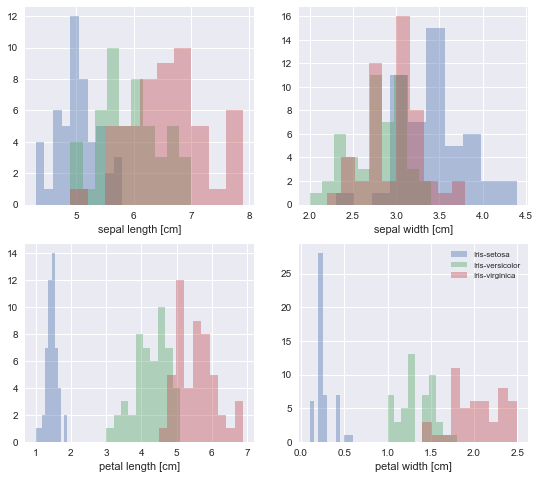

In [79]:
feature_dict = {0: 'sepal length [cm]', 1: 'sepal width [cm]', 2: 'petal length [cm]', 3: 'petal width [cm]'}

plt.figure(figsize = (9, 8)) 
for cnt in range(4):
    plt.subplot(2, 2, cnt + 1)
    for lab in ('Iris-setosa', 'Iris-versicolor', 'Iris-virginica'):
        plt.hist(X[y == lab, cnt], label = lab, bins = 10, alpha = 0.4)
    plt.xlabel(feature_dict[cnt])
plt.legend(loc = 'upper right', fancybox = True, fontsize = 8)

In [83]:
# X[:, 0][y == 'Iris-setosa']
# X[y == 'Iris-setosa', 0]

array([ 5.1,  4.9,  4.7,  4.6,  5. ,  5.4,  4.6,  5. ,  4.4,  4.9,  5.4,
        4.8,  4.8,  4.3,  5.8,  5.7,  5.4,  5.1,  5.7,  5.1,  5.4,  5.1,
        4.6,  5.1,  4.8,  5. ,  5. ,  5.2,  5.2,  4.7,  4.8,  5.4,  5.2,
        5.5,  4.9,  5. ,  5.5,  4.9,  4.4,  5.1,  5. ,  4.5,  4.4,  5. ,
        5.1,  4.8,  5.1,  4.6,  5.3,  5. ])

### Standardizing 

In [96]:
# transform the data onto unit scale(mean = 0, variance = 1)
from sklearn.preprocessing import StandardScaler 
X_std = StandardScaler().fit_transform(X)

### Eigendecomposition

In [101]:
# eigen pairs of hte covarince matrix
# eigenvalues explain the variance of the data along the new feature axes.

mean_vec = np.mean(X_std, axis = 0)
cov_mat = (X_std - mean_vec).T.dot(X_std - mean_vec)/ (X_std.shape[0] - 1)

print(cov_mat)

[[ 1.00671141 -0.11010327  0.87760486  0.82344326]
 [-0.11010327  1.00671141 -0.42333835 -0.358937  ]
 [ 0.87760486 -0.42333835  1.00671141  0.96921855]
 [ 0.82344326 -0.358937    0.96921855  1.00671141]]


In [106]:
# eigen decomposition on covariance matrix

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print ('Eigen values \n%s' %eig_vals)
print ('Eigen vectors \n%s' %eig_vec)

Eigen values 
[ 2.93035378  0.92740362  0.14834223  0.02074601]
Eigen vectors 
[[ 0.52237162 -0.37231836 -0.72101681  0.26199559]
 [-0.26335492 -0.92555649  0.24203288 -0.12413481]
 [ 0.58125401 -0.02109478  0.14089226 -0.80115427]
 [ 0.56561105 -0.06541577  0.6338014   0.52354627]]


While the eigendecomposition of the covariance or correlation matrix may be more intuitiuve, most PCA implementations perform a Singular Vector Decomposition (SVD) to improve the computational efficiency.

In [105]:
u, s, v = np.linalg.svd(X_std.T)
print ('Vectors \n%s' %u)

Vectors 
[[-0.52237162 -0.37231836  0.72101681  0.26199559]
 [ 0.26335492 -0.92555649 -0.24203288 -0.12413481]
 [-0.58125401 -0.02109478 -0.14089226 -0.80115427]
 [-0.56561105 -0.06541577 -0.6338014   0.52354627]]


### Selecting Principal Components 

In [123]:
# sort the eigen pairs 
# eigen vecotr only defines the direction of the new axis. they have the same unit length of 1.
# rank eigenvalues form top to bottom and select the top K (K < d) with the corresponding eigen vectors for the new axis 

# list of eigenpair tuples 
# according to the documentation - the column ``v[:,i]`` is the eigenvector corresponding to the eigenvalue ``w[i]``.
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:, i]) for i in range(len(eig_vals))]

# sort the eign pairs list of tuples from high to low 
eig_pairs.sort(key = lambda x: x[0], reverse = True)

# confirm that the list is sorted correctly 
for i in eig_pairs:
    print (i[0])

2.93035377559
0.927403621517
0.148342226482
0.0207460139956


### Explained variance 

The explained variance tells how much information(variance) can be attributed to each of the principal components.

In [125]:
# calculate explained varince using eigen values, as stated in the attribute of Trace(Matrix)

tot = sum(eig_vals)
var_exp = [(i/ tot * 100) for i in sorted(eig_vals, reverse = True)]
cum_var_exp = np.cumsum(var_exp)

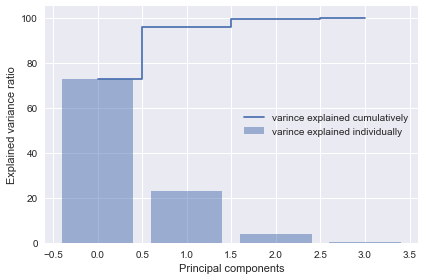

In [126]:
plt.figure(figsize = (6, 4))

plt.bar(range(4), var_exp, alpha = 0.5, align = 'center', label = 'varince explained individually')
plt.step(range(4), cum_var_exp, where = 'mid', label = 'varince explained cumulatively')

plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc = 'best')
plt.tight_layout()

The plot above clearly shows that most of the variance (72.77% of the variance to be precise) can be explained by the first principal component alone. The second principal component still bears some information (23.03%) while the third and fourth principal components can safely be dropped without losing to much information. Together, the first two principal components contain 95.8% of the information.

### Projection Matrix

Construct the projection matrix that will be used to transform the Iris data onto the new feature subspace, which is a matrix of the top k concatenated eigenvectors.

We are reducing the number of eigen vectors from 4 to 2 here by choosing the top 2 eigen vectors with the highest eigen values. The projection matrix will have the shape of d x k, where k is the number of chosen eigen vectors, d is the number of dimensions in the original dataset. Each column is a principal component in the projection matrix. 

In [133]:
# Stack the arrays horizontally(column wise) 
# the goal is to contruct a 2d matrix from the first two eigen vectors- reshape the np arrays

matrix_w = np.hstack((eig_pairs[0][1].reshape(4, 1), eig_pairs[1][1].reshape(4, 1)))
print (matrix_w)

[[ 0.52237162 -0.37231836]
 [-0.26335492 -0.92555649]
 [ 0.58125401 -0.02109478]
 [ 0.56561105 -0.06541577]]


### Data projection onto new feature space 

Transform data from the original feature space to the new subsapce by using Y = X x W, where Y is  150 x 2 matrix of the tranformed data.

http://www4.ncsu.edu/~slrace/LinearAlgebra2017/Slides/PCAPrint.pdf

In [134]:
Y = X_std.dot(matrix_w)

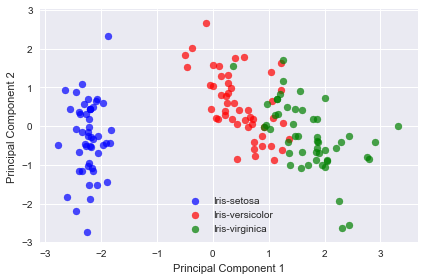

In [142]:
plt.figure(figsize = (6, 4))

# zip method returns a tuple
for lab, col in zip(('Iris-setosa', 'Iris-versicolor', 'Iris-virginica'), ('blue', 'red', 'green')):
    plt.scatter(Y[y == lab, 0], Y[y == lab, 1], label = lab, c = col, alpha = 0.7)
    
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(loc = 'lower center')
plt.tight_layout()

In [143]:
# built in PCA

from sklearn.decomposition import PCA as sklearnpca
sklearn_pca = sklearnpca(n_components = 2)
y_sklearn = sklearn_pca.fit_transform(X_std)

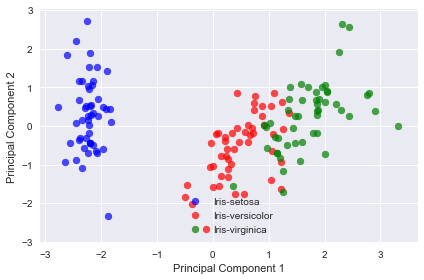

In [150]:
plt.figure(figsize = (6, 4))

for lab, col in zip(('Iris-setosa', 'Iris-versicolor', 'Iris-virginica'), ('blue', 'red', 'green')):
    plt.scatter(y_sklearn[y == lab, 0], y_sklearn[y == lab, 1], label = lab, c = col, alpha = 0.7)
    
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(loc='lower center')
plt.tight_layout()

In [145]:
help(sklearn_pca.fit)

Help on method fit in module sklearn.decomposition.pca:

fit(X, y=None) method of sklearn.decomposition.pca.PCA instance
    Fit the model with X.
    
    Parameters
    ----------
    X: array-like, shape (n_samples, n_features)
        Training data, where n_samples in the number of samples
        and n_features is the number of features.
    
    Returns
    -------
    self : object
        Returns the instance itself.



In [146]:
help(sklearn_pca.transform)

Help on method transform in module sklearn.decomposition.base:

transform(X, y=None) method of sklearn.decomposition.pca.PCA instance
    Apply dimensionality reduction to X.
    
    X is projected on the first principal components previously extracted
    from a training set.
    
    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        New data, where n_samples is the number of samples
        and n_features is the number of features.
    
    Returns
    -------
    X_new : array-like, shape (n_samples, n_components)
    
    Examples
    --------
    
    >>> import numpy as np
    >>> from sklearn.decomposition import IncrementalPCA
    >>> X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
    >>> ipca = IncrementalPCA(n_components=2, batch_size=3)
    >>> ipca.fit(X)
    IncrementalPCA(batch_size=3, copy=True, n_components=2, whiten=False)
    >>> ipca.transform(X) # doctest: +SKIP



In [147]:
help(sklearn_pca.fit_transform)

Help on method fit_transform in module sklearn.decomposition.pca:

fit_transform(X, y=None) method of sklearn.decomposition.pca.PCA instance
    Fit the model with X and apply the dimensionality reduction on X.
    
    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        Training data, where n_samples is the number of samples
        and n_features is the number of features.
    
    Returns
    -------
    X_new : array-like, shape (n_samples, n_components)



**Consider the following points when choosing the method of matrix decomposition:**

- all of them approximate the matrix in some way.
- some may make the problem easier to solve.
- the algorithm.
  - Is there an efficient way to find the decomposition? (especially for large matrices. for example SVD is computed more efficiently for large matrices than eigen-decomposition.)
  - Can we obtain it with an online algorithm? (updating factorization when new data samples comes in without recomputing all the steps)
  
**Some points on the reason of matrix decompostion.**

How do you actually solve a large system of linear equations on a computer and how do you actually diagonalize a large matrix (that theory tells you is diagonalizable) on a computer. These are very difficult problems since there is a huge gap between the theoretical results and actual computations. That gap is caused of course by rounding errors on a computer. Loads of books are written on the subject as, needless to say, it's of immense importance. Many factorizations of matrices (e.g., LU and QR) are meant to address such issues. To make computations more robust and more efficient.

...


### PCA

PCA finds a matrix Q that, when multiplied by the original data matrix X, returns a linearly transformed data matrix Z, where:

#### Z = XQ

The interesting thing about PCA is how it chooses Q.

PCA reduces dimensionality by moving as much “information” as possible into as few dimensions as possible. The information here is measured by unpredictability, i.e. variance. The end result is that the transformed matrix Z has most of its variance in the first column, less variance in the second column, even less variance in the third column, etc.

### Eigenvalues & Eigenvectors

when multiply a vector by a matrix, the direction of the vector is changed.

Eigenvalues λ and eigenvectors v have the property that, if multiplied by a matrix, say A, is the same as multiplying the eigenvector by a constant – the eigenvalue, i.e. the eigenvector does not change direction, it only gets shorter or longer by a factor of λ. In other words:

#### Av = λv

where A is the matrix, v is the eigenvector and λ the eigenvalue.

In the case of PCA, all the eigenvectors from the empirical covariance matrix are lined upsuch that the corresponding λ, eigenvallues, are in descending order. In matrix form, the above can be expressed by:

#### AV = VΛ

where V is the matrix with eigenvectors as columns, which is orthonormal, and Λ is a diagonal matrix of eigenvalues.


### SVD, Matrix Diagonalization in finding the eigenpairs

The method from textbook – solving a polynomial to get the eigenvalues, plugging the eigenvalues into the eigenvalue equation to get the eigenvectors, etc. doesn’t really translate to computer code.

#### SVD

- Square the diagonal matrix S, and divide by sum(S) to obtain eigenvalues
- Matrix Vt (or U) will contain the eigenvectors


Since Λ is a diagonal matrix, there are no correlations in the transformed data.

** The variance of each dimension of Z is equal to the eigenvalues.**

In addition, because we sorted the eigenvalues in descending order, the first dimension/coluumn of Z has the most variance, the second dimension/coluumn has the second-most variance, etc. So most of the information is kept in the leading dimensions/columns, as promised.


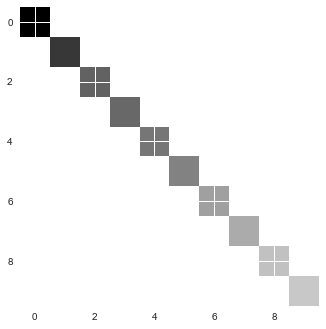

In [19]:
pca = PCA()

x = np.random.random((100,10)) # generate an N = 100, D = 10 random data matrix

# 1. find the principal components which are the linear combiation of the origianl data dimensions. 
# The full set of principal components has the same number as the number of dimensions in the original dataset
# 2. project the data to the span consists of the full set of principal components 

z = pca.fit_transform(x)

# visualize the covariance of the principal components in z
plt.imshow(np.cov(z.T))
plt.show()

In [18]:
# PCA summary function - where the input variable pca is a PCA object

def pca_summary(pca, standardised_data, out = True):
    names = ["PC" + str(i) for i in range(1, len(pca.explained_variance_ratio_) +  1)]
    
    a = list(np.std(pca.transform(standardised_data), axis = 0))
    
    # the highest eigenvalue indicates the highest variance in the data was observed in the direction of its eigenvector
    # The first principal component is calculated such that it accounts for the greatest possible variance in the data set.
    b = list(pca.explained_variance_ratio_)
    c = [np.sum(pca.explained_variance_ratio_[:i]) for i in range(1, len(pca.explained_variance_ratio_) + 1)]
    
    columns = pd.MultiIndex.from_tuples([("sdev", "Standard deviation"), ("varprop", "Proportion of Variance"), ("cumprop", "Cumulative Proportion")])
    summary = pd.DataFrame(list(zip(a, b, c)), index = names, columns = columns)
    
    if out:
        print("Importance of components:")
#         display(summary)
    
    return summary

###  The first PC preserves the largest variance in the projected data 

In [4]:
pca = PCA().fit(x)
summary = pca_summary(pca, x)
summary

Importance of components:


,sdev,varprop,cumprop
,Standard deviation,Proportion of Variance,Cumulative Proportion
PC1,0.359499,0.162672,0.162672
PC2,0.333629,0.140103,0.302775
PC3,0.306590,0.118314,0.421089
PC4,0.288277,0.104602,0.525691
PC5,0.271000,0.092439,0.618130
PC6,0.265269,0.088571,0.706701
PC7,0.252984,0.080557,0.787258
PC8,0.245934,0.076130,0.863388
PC9,0.240030,0.072519,0.935906


In [5]:
print (np.std(pca.transform(x), axis = 0))
print (np.std(pca.transform(x)[:, 0]))

# the first PC preserves the greatest variance in the projected data 
onedim = PCA(n_components = 1).fit_transform(x)
np.std(onedim)

[ 0.35949925  0.33362928  0.3065904   0.28827738  0.27100002  0.26526869
  0.25298445  0.24593386  0.2400301   0.22565688]
0.359499251521


0.35949925152149775

#### Observe that the off-diagonals are 0 and that the variances are in decreasing order. Can also confirm that QTQ=I.

In [6]:
# show the full set of principal components 
pca.components_

array([[ 0.46898991, -0.08504879,  0.1869969 , -0.34550821,  0.46180893,
         0.30755472,  0.14620205,  0.09092644, -0.31493179,  0.42636758],
       [ 0.24653261, -0.38227058,  0.12029659,  0.14602039, -0.29251086,
         0.16114432, -0.48974683, -0.39295611, -0.46948189, -0.17631746],
       [ 0.36667878,  0.01889615, -0.47158942, -0.35084926, -0.1369054 ,
         0.26549766,  0.18531684, -0.45418513,  0.38621394, -0.20168802],
       [ 0.27506536,  0.10508615, -0.30994671, -0.14350025,  0.26033994,
        -0.50966752, -0.64800353,  0.08460151,  0.15060151,  0.13911143],
       [ 0.00262817, -0.37120536,  0.60527104, -0.49256533, -0.16957931,
        -0.25520077, -0.03249754, -0.00799016,  0.39120344, -0.07198192],
       [-0.52427818, -0.5019041 , -0.42880928, -0.34185703,  0.07809983,
        -0.15679051,  0.0998848 , -0.12831047, -0.26288225,  0.21505944],
       [ 0.08612727, -0.0634536 , -0.20127949, -0.33020301, -0.16425799,
         0.16123443, -0.06664213,  0.68968947

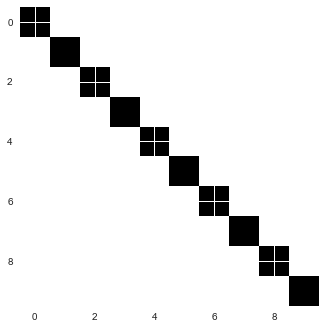

[[ 1.  0. -0. -0.  0.  0.  0. -0.  0. -0.]
 [ 0.  1.  0.  0. -0. -0. -0. -0.  0. -0.]
 [-0.  0.  1.  0.  0. -0.  0.  0. -0.  0.]
 [-0.  0.  0.  1.  0. -0.  0.  0.  0.  0.]
 [ 0. -0.  0.  0.  1.  0.  0. -0. -0.  0.]
 [ 0. -0. -0. -0.  0.  1. -0. -0. -0.  0.]
 [ 0. -0.  0.  0.  0. -0.  1.  0. -0. -0.]
 [-0. -0.  0.  0. -0. -0.  0.  1. -0. -0.]
 [ 0.  0. -0.  0. -0. -0. -0. -0.  1.  0.]
 [-0. -0.  0.  0.  0.  0. -0. -0.  0.  1.]]


In [17]:
QTQ = pca.components_.T.dot(pca.components_)
plt.imshow(QTQ)
plt.show()

print (np.around(QTQ, decimals=2))

#### PCA is fundamentally a dimensionality reduction algorithm, but it can also be useful as a tool for visualization, for noise filtering, for feature extraction and engineering, and much more.

(-2.7378957575985226,
 2.5788989913065881,
 -0.94549527304399739,
 1.0172909457553052)

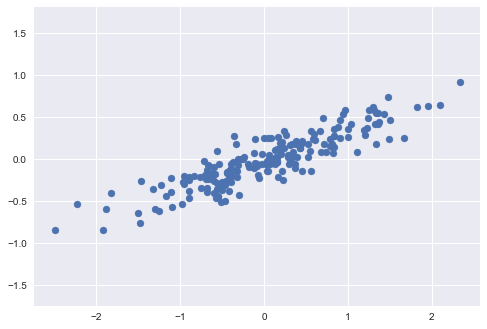

In [15]:
rng = np.random.RandomState(1)

X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal')

Unlike Linear Regression, rather than attempting to predict the y values from the x values, the unsupervised learning method PCA attempts to learn about the relationship between the x and y values. In principal component analysis, this relationship is quantified by finding a list of the principal axes in the data, and using those axes to describe the dataset.

In [21]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)


The fit learns some quantities from the data, most importantly the "components" and "explained variance":

In [ ]:
print(pca.components_)
print ('==')
print(pca.explained_variance_)

visualize the numbers as vectors over the input data, using the 'components' to define the directions of the vectors and the **'explained varaince' to define the squared length of the vectors**

In [23]:
def draw_vector(v0, v1, ax = None):
    ax = ax or plt.gca()
    arrowprops = dict(arrowstyle = '->', linewidth = 2, shrinkA = 0, shrinkB = 0)
    ax.annotate('', v1, v0, arrowprops = arrowprops)

(-2.7378957575985226,
 2.5788989913065881,
 -0.94549527304399739,
 1.0172909457553052)

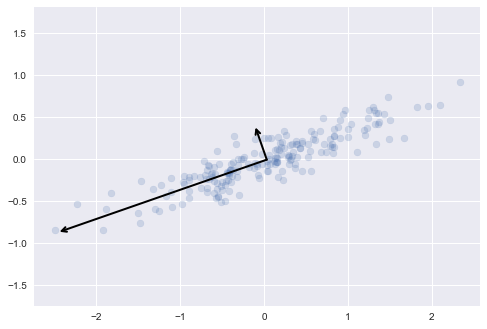

In [24]:
plt.scatter(X[:, 0], X[:, 1], alpha = 0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal')

These vectors represent the principal axes of the data, and the length of the vector is an indication of how "important" that axis is in describing the distribution of the data—more precisely, it is a measure of the variance of the data when projected onto that axis. The projection of each data point onto the principal axes are the "principal components" of the data.

In [36]:
# Using PCA for dimensionality reduction involves zeroing out one or more of the smallest principal components, resulting in a lower-dimensional projection of the data that preserves the maximal data variance.

pca = PCA(n_components = 1)
pca.fit(X)
X_pca = pca.transform(X)

print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (200, 2)
transformed shape: (200, 1)


The transformed data is redudced to one dimension.

** perform inverse transformation of this reduced data and plot it along with the original data.**

(-2.7649537820213026,
 2.6551825979217609,
 -0.99198805419665281,
 1.0195048877149555)

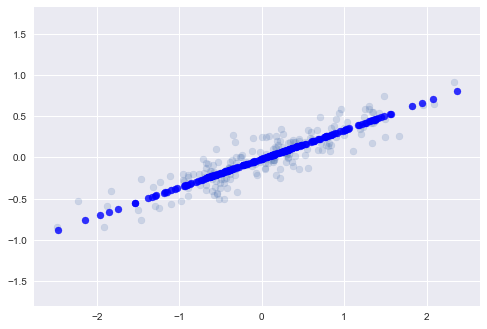

In [38]:
X_new = pca.inverse_transform(X_pca)

plt.scatter(X[:, 0], X[:, 1], alpha = 0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha = 0.8, color = 'b')
plt.axis('equal')

The light points are the original data, while the dark points are the projected version. This makes clear what a PCA dimensionality reduction means: the information along the least important principal axis or axes is removed, leaving only the component(s) of the data with the highest variance. The fraction of variance that is cut out (proportional to the spread of points about the line formed in this figure) is roughly a measure of how much "information" is discarded in this reduction of dimensionality. This reduced-dimension dataset is in some senses "good enough" to encode the most important relationships between the points: despite reducing the dimension of the data by 50%, the overall relationship between the data points are mostly preserved.


The purpose of principal component analysis is to find the best low-dimensional representation of the variation in a multivariate data set. For example, in the case of the wine data set, we have 13 chemical concentrations describing wine samples from three different cultivars. We can carry out a principal component analysis to investigate whether we can capture most of the variation between samples using a smaller number of new variables (principal components), where each of these new variables is a linear combination of all or some of the 13 chemical concentrations.

Principal Component Analysis (PCA) Vs. Multiple Discriminant Analysis (MDA) 

- Both are **linear** transformation methods and closely related to each other.

- In PCA, we are interested to find the directions (components) that maximize the variance of the projected dataset, where in MDA, we are additionally interested to find the directions that maximize the separation (or discrimination) between different classes (for example, in pattern classification problems where our dataset consists of multiple classes. In contrast to PCA, which ignores the class labels). In other words, via PCA, we are projecting the entire set of data (without class labels) onto a different subspace, and in MDA, we are trying to determine a suitable subspace to distinguish between patterns that belong to different classes. Or, roughly speaking in PCA we are trying to find the axes with maximum variances where the data is most spread (within a class, since PCA treats the whole data set as one class), and in MDA we are additionally maximizing the spread between classes. In typical pattern recognition problems, a PCA is often followed by an MDA.(classificaiton mostly, or is regression considered as well)

**PCA Steps:**

- Take the whole dataset consisting of d-dimensional samples ignoring the class labels
- Compute the d-dimensional mean vector (i.e., the means for every dimension/ feature/ column of the whole dataset)
- Compute the scatter matrix (alternatively, the covariance matrix) of the whole dataset
- Compute eigenvectors (e1,e2,...,ed) and corresponding eigenvalues (λ1,λ2,...,λd)
- Sort the eigenvectors by decreasing eigenvalues and choose k eigenvectors with the largest eigenvalues to form a d×k dimensional matrix W (where every **column** represents an eigenvector)
- Use this **d×k eigenvector matrix to transform the samples onto the new subspace.** This can be summarized by the mathematical equation: y = W Transpose × x (where x is a d×1-dimensional vector representing one sample, and y is the transformed **k×1-dimensional sample in the new subspace.**)

PCA is mathematically defined as an orthogonal linear transformation that transforms the data into a new coordinate system such that the greatest varince by some projection of the data comes to lie on the first coordinate (first Principal Component), the second greatest varince on the second coordinate, and so on.


#### Feature scaling

Since the range of values of raw data varies widely, in some machine learning algorithms, the objective function of the algorithm may not work properly without normalization. For example, the majority classifiers calculate the distance between two points by the Euclidean distance. If one of the features has a broad range of values, the distance will be governed by this feature. Therefore, the range of all features should be normalized so that each feature contributes approximately proportionately to the final distance.

Another reason for feature scalling is that gradient descent converges much faster with features scaled than without. (wiki feature sacling)

http://sebastianraschka.com/Articles/2014_about_feature_scaling.html

http://ufldl.stanford.edu/tutorial/unsupervised/PCAWhitening/

**PCA**

- purpose of mean vector subtraction from the data matrix (normalizing the data) before PCA

  - makes the math easier in calculating the covariance matrix and its decomposition
  - plus it does not affect the varince information in the original data matrix
- if it is to standerdize the data matrix (deducting the mean vector and dividing the standard deviation)

  - variance for all features are kept to the same [0,1] range
  - covariance matrix is not affected

Technically PCA includes centering (mean subtraction) of the data. This is done in order to calculate the covariance matrix. Eigendecomposition is then applied to the covariance matrix, with the eigenvalues corresponding to the variance of the data along the eigenvectors.

An alternative, but equivalent approach, is to use a singular value decomposition (SVD) of the data matrix. Mean subtraction must be done prior to the SVD in order for this to be equivalent.

Normalization (dividing by the variance) is not necessary.

**SVD**

https://alyssaq.github.io/2015/singular-value-decomposition-visualisation/